# Base Imports

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load Data

In [2]:
TRAIN_SIZE = 0.8
PATH = 'data/'

classes = ["Mujeres", "LGBT", "Migrantes", "Pueblos Originarios"]
data_train = pd.read_csv(PATH+'tweets_train.csv')

train_data = data_train.sample(frac=1).reset_index(drop=True)
train_data, val_data = train_data.iloc[:int(TRAIN_SIZE*len(train_data)), :], train_data.iloc[int(TRAIN_SIZE*len(train_data)):, :]

print(train_data.shape)
print(val_data.shape)

#train_data.head(5)
#val_data.head(5)

(1804, 10)
(452, 10)


# Preprocess Data

In [3]:
# Considerar que un dato pertenece solo si las 3 personas pusieron que pertenece
limite = 3

train_data['Odio'] = np.where(train_data['Odio'] == limite, 1, 0)
train_data['Mujeres'] = np.where(train_data['Mujeres'] == limite, 1, 0)
train_data['Comunidad LGBTQ+'] = np.where(train_data['Comunidad LGBTQ+'] == limite, 1, 0)
train_data['Comunidades Migrantes'] = np.where(train_data['Comunidades Migrantes'] == limite, 1, 0)
train_data['Pueblos Originarios'] = np.where(train_data['Pueblos Originarios'] == limite, 1, 0)

val_data['Odio'] = np.where(val_data['Odio'] == limite, 1, 0)
val_data['Mujeres'] = np.where(val_data['Mujeres'] == limite, 1, 0)
val_data['Comunidad LGBTQ+'] = np.where(val_data['Comunidad LGBTQ+'] == limite, 1, 0)
val_data['Comunidades Migrantes'] = np.where(val_data['Comunidades Migrantes'] == limite, 1, 0)
val_data['Pueblos Originarios'] = np.where(val_data['Pueblos Originarios'] == limite, 1, 0)

#train_data.head(5)
#val_data.head(5)

In [4]:
train_tweets = train_data['text'].values
val_tweets = val_data['text'].values

In [5]:
def clean_text(text):
  TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
  TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
  TEXT_CLEAN_CHAR = "(\s\w\s)"
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
  text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
  text = re.sub(TEXT_CLEAN_CHAR, ' ', str(text).lower()).strip()
  return text

In [6]:
#nltk.download('wordnet')
#nltk.download('stopwords')
stop_words = stopwords.words("spanish")

In [7]:
stemmer = SnowballStemmer("spanish")

def preprocess(text,cleaning=True,stopwords=True,stemming=True):
    if cleaning:
      text = clean_text(text)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
cleaned_train = [preprocess(tweet, stemming=False) for tweet in train_tweets]
cleaned_val = [preprocess(tweet, stemming=False) for tweet in val_tweets]

In [9]:
PATH_ODIO = 'Odio/'
PATH_CATEGORIAS = 'Categorias/'
N_MAX_WORDS = 5000
MAX_TEXT_LENGTH = 25

In [10]:
Seq_tokenizer = Tokenizer(num_words=N_MAX_WORDS)
Seq_tokenizer.fit_on_texts(cleaned_train)

train_sequences = Seq_tokenizer.texts_to_sequences(cleaned_train)
val_sequences = Seq_tokenizer.texts_to_sequences(cleaned_val)

train_sequences = pad_sequences(train_sequences, maxlen=MAX_TEXT_LENGTH)
val_sequences = pad_sequences(val_sequences, maxlen=MAX_TEXT_LENGTH)

In [11]:
TF_tokenizer = Tokenizer(num_words=N_MAX_WORDS)
TF_tokenizer.fit_on_texts(cleaned_train)

In [12]:
train_vectors = TF_tokenizer.texts_to_matrix(cleaned_train, mode='tfidf')
val_vectors = TF_tokenizer.texts_to_matrix(cleaned_val, mode='tfidf')

# Codificar Clases

In [13]:
x_train_odio = train_vectors
y_train_odio = train_data['Odio'].values
x_val_odio = val_vectors
y_val_odio = val_data['Odio'].values

print(x_train_odio.shape)
print(y_train_odio.shape)
print(x_val_odio.shape)
print(y_val_odio.shape)

(1804, 5000)
(1804,)
(452, 5000)
(452,)


In [14]:
x_train_categorias = train_vectors
y_train_categorias = train_data[['Mujeres', 'Comunidad LGBTQ+', 'Comunidades Migrantes', 'Pueblos Originarios']].values
x_val_categorias = val_vectors
y_val_categorias = val_data[['Mujeres', 'Comunidad LGBTQ+', 'Comunidades Migrantes', 'Pueblos Originarios']].values

print(x_train_categorias.shape)
print(y_train_categorias.shape)
print(x_val_categorias.shape)
print(y_val_categorias.shape)

(1804, 5000)
(1804, 4)
(452, 5000)
(452, 4)


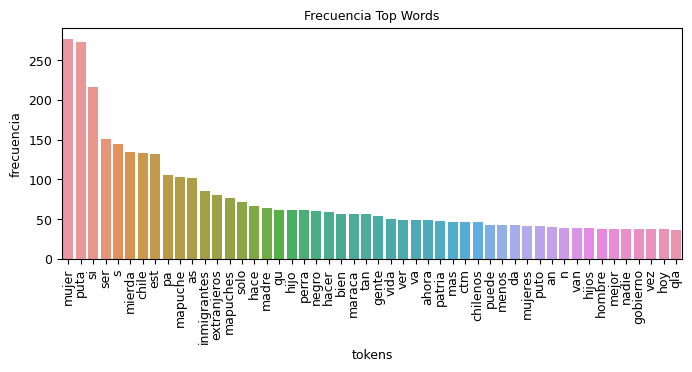

In [15]:
n_print_words = 50
wcounts = list(TF_tokenizer.word_counts.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
top_words = wcounts[:n_print_words]

fig, ax = plt.subplots(figsize=(8,3),nrows=1)
ax.set_title('Frecuencia Top Words',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

# Model - Odio

In [16]:
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro', num_classes=1)
]

### Entrenar modelo nuevo

In [17]:
def FNN(num_words=5000):
  input = keras.Input(shape=(num_words))
  hidden = keras.layers.Dense(50, activation='relu')(input)
  hidden = keras.layers.Dense(20, activation='relu')(hidden)
  output = keras.layers.Dense(1, activation="sigmoid")(hidden)
  model_dense = tf.keras.Model(inputs=input, outputs=output)
  return model_dense

In [18]:
modelo_denso = FNN(num_words=5000)
#modelo_denso.summary()

In [19]:
modelo_denso = FNN(num_words=5000)
opt =  Adam()

modelo_denso.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)

checkpoint_path = 'FNN_checkpoints/FNN.{epoch:02d}-{val_accuracy:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_accuracy',mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max')
historial_FF = modelo_denso.fit(x_train_odio, y_train_odio, batch_size=32, epochs=40, verbose=2, validation_data=(x_val_odio, y_val_odio), callbacks=[es,cp_callback])

Epoch 1/40
57/57 - 1s - loss: 0.6032 - accuracy: 0.6901 - F1: 0.4279 - val_loss: 0.5451 - val_accuracy: 0.7412 - val_F1: 0.4494 - 1s/epoch - 20ms/step
Epoch 2/40
57/57 - 0s - loss: 0.2783 - accuracy: 0.9141 - F1: 0.4279 - val_loss: 0.4829 - val_accuracy: 0.8031 - val_F1: 0.4494 - 150ms/epoch - 3ms/step
Epoch 3/40
57/57 - 0s - loss: 0.1056 - accuracy: 0.9734 - F1: 0.4279 - val_loss: 0.5605 - val_accuracy: 0.7942 - val_F1: 0.4494 - 136ms/epoch - 2ms/step
Epoch 4/40
57/57 - 0s - loss: 0.0441 - accuracy: 0.9884 - F1: 0.4279 - val_loss: 0.6207 - val_accuracy: 0.7898 - val_F1: 0.4494 - 129ms/epoch - 2ms/step
Epoch 5/40
57/57 - 0s - loss: 0.0231 - accuracy: 0.9956 - F1: 0.4279 - val_loss: 0.6756 - val_accuracy: 0.7942 - val_F1: 0.4494 - 134ms/epoch - 2ms/step


### Guardar Modelo

In [20]:
modelo_denso.summary()
modelo_denso.save(PATH_ODIO+'Modelo_denso.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense_3 (Dense)             (None, 50)                250050    
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 251,091
Trainable params: 251,091
Non-trainable params: 0
_________________________________________________________________


# Modelo - Categorias

### Entrenar modelo nuevo

In [21]:
import tensorflow_hub as hub
import bert
from bert.tokenization.bert_tokenization import FullTokenizer

In [22]:
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro', num_classes=len(classes))
]

In [23]:
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(bert_path, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [24]:
def prepare_input_for_bert(texts, bert_tokenizer, max_seq_len):
  x, y, z =[],[], []
  for text in texts:
    tokens = bert_tokenizer.tokenize(text)
    tokens = tokens[:min(len(tokens),max_seq_len-2)]
    tokens = ["[CLS]"]+tokens+["[SEP]"]
    token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_len-len(token_ids))
    input_mask = ([1] * len(token_ids)) + ([0] *  (max_seq_len - len(token_ids)))
    input_type = ([0] * (len(token_ids)-1)) + [1] + ([0] *  (max_seq_len - len(token_ids)))
    x.append(np.array(input_ids))
    y.append(np.array(input_mask))
    z.append(np.array(input_type))
  return [tf.cast(np.array(x),tf.int32), tf.cast(np.array(y),tf.int32), tf.cast(np.array(z),tf.int32)]

In [25]:
def bert_based_model(max_seq_len):

  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  input_mask = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_masks")
  input_segments = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_segments")
  pooled_output, sequence_output = bert_layer([input_ids, input_mask, input_segments])
  cls_out = keras.layers.GlobalAveragePooling1D()(sequence_output)
  logits = keras.layers.Dropout(0.7)(cls_out)
  logits = keras.layers.Dense(768)(logits)
  logits = keras.layers.Dropout(0.7)(logits)
  logits = keras.layers.Dense(len(classes), activation="sigmoid")(logits)
  classifier = keras.Model([input_ids, input_mask, input_segments],logits)

  return classifier

In [26]:
max_seq_len=50
bert_input_train = prepare_input_for_bert(train_tweets,bert_tokenizer,max_seq_len)
bert_input_val = prepare_input_for_bert(val_tweets,bert_tokenizer,max_seq_len)
print(bert_input_train[0].shape)

(1804, 50)


In [27]:
bert_model = bert_based_model(max_seq_len)
bert_model.summary()
bert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 50, 768)]                 'input_masks[0][0]',      

In [28]:
checkpoint_path = 'BERT_based_checkpoints/BERT_based.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_bert_model = bert_model.fit(bert_input_train, y_train_categorias, epochs=40, batch_size=32, validation_data=(bert_input_val, y_val_categorias), callbacks=[es])

57/57 [==============================] - 250s 4s/step - loss: 0.4159 - accuracy: 0.7687 - F1: 0.1302 - val_loss: 0.2929 - val_accuracy: 0.9098 - val_F1: 0.1549


### Guardar Modelo

In [30]:
bert_model.summary()
bert_model.save(PATH_CATEGORIAS+'Modelo.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 50, 768)]                 'input_masks[0][0]',      